<a id='top'></a>
# Working with NSIDC DAAC/NOAA data in R
---
This notebook was built to answer basic R user questions and provide use cases for working with NSIDC/NOAA data formats in R. The Jupyter Notebook uses an R kernel so that the R syntax and packages/libraries can be used. All code can be copied and pasted directly into R Studio for running in a local environment.

Please send any questions, comments, or use cases of interest to NSIDC User Services at nsidc@nsidc.org

### Notebook Sections
_Click link to jump to section of interest_
1. Working with [<b>NetCDF 4 (.nc)</b>](#netcdf)
2. Working with [<b>HDF5 (.hdf)</b>](#hdf)
3. Working with [<b>.he5</b>](#he5)
4. Working with [<b>Binary (.bin)</b>](#bin)
5. Working with [<b>multiple datasets</b>](#mult)

_Other topics to add:_
- Working with multiple datasets (MeaSUREs: https://nsidc.org/data/NSIDC-0484/versions/2? NSIDC-0715, NSIDC-0481, -0642)
- Advanced plotting with GGPLOT

---
### **_Start Here_:** Steps for setting up your JupyteR environment
Step 1. Activate or create conda environment: <i>conda create -n yourenvname r-base r-ncdf4 r-raster r-gdalUtils r-rgdal r-tidyverse</i>

Step 2. Run <i>conda install -c r r-irkernel</i>

Step 3. Run <i>conda install r-base (unless you did it with a new environment)</i>

Step 4. Run <i>conda install r-essentials (includes tidyverse, shiny, etc.)</i>

   <i>Note:</i> Any R package you want to install with conda should be written as "r-<i>packagename</i>"

<b>Load packages and choose working directory</b>


In [87]:
libraries <- c("ncdf4", "rgdal", "gdalUtils", "raster", "rnaturalearth", "rnaturalearthdata", "ggplot2", "sf", "dplyr", "ggmap")
invisible(lapply(libraries, library, character.only = TRUE))

---
<a id='netcdf'></a>
## 1. Working with <b>NetCDF 4</b> files in R
Package:<b> ncdf4 </b>Dataset:<b> SnowEx 2020 Airborne DEM Mosaic (pre-release)</b>

In [88]:
setwd("C:/Users/niko8816/Projects/tutorials/data/snowex")
path <- getwd()
print(path)

[1] "C:/Users/niko8816/Projects/tutorials/data/snowex"


In [89]:
# set data path and filename
ncpath <- "C:/Users/niko8816/Projects/tutorials/data/snowex/"
ncname <- "SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW"
ncfname <- paste(ncpath, ncname, ".nc", sep="")

In [90]:
# open a netCDF file
ncin <- nc_open(ncfname)
print(ncin)

# Open the file using rgdal method 
snex <- "SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc"

File C:/Users/niko8816/Projects/tutorials/data/snowex/SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc (NC_FORMAT_NETCDF4_CLASSIC):

     5 variables (excluding dimension variables):
        float RGBmosaic[northing, y,easting, x,RGB channels,pass]   
            units: scaled intensity
            description: RGB imagery
        float DEM[northing, y,easting, x]   
            description: digital elevation map used for georectification
            source: https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1-arc?qt-science_center_objects=0#qt-science_center_objects
            horizontal datum: WGS84
            vertical datum: EGM96
            units: meters
            original resolution: 30 m / 1 arc-second
        double E_UTM[northing, y,easting, x]   
            description: eastings, WGS84, UTM MGRS 13S
            units: meters
            dx: 5
        double N_UTM[northing, y,easting, x]   
            descr

In [91]:
# Get subdatasets so that you can grab the parameter slice you're interested in
sds <- get_subdatasets(snex)
sds

[1] "NETCDF:SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc:RGBmosaic"
[2] "NETCDF:SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc:DEM"      
[3] "NETCDF:SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc:E_UTM"    
[4] "NETCDF:SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc:N_UTM"    
[5] "NETCDF:SNOWEX2020_EO_PLANE_2020Feb08_mosaicked_APLUW.nc:time"

In [92]:
# Convert your parameter slice to .tif and save to local directory
gdal_translate(sds[2], dst_dataset = "SNEX20_DEM_NK_QC_02102021_v3.tif")

NULL

In [97]:
# Pull the new .tif raster back into R and examine the data
dem <- raster("SNEX20_DEM_NK_QC_02102021_v3.tif")
show(dem)

class      : RasterLayer 
dimensions : 4171, 3581, 14936351  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 0, 3581, 0, 4171  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : C:/Users/niko8816/Projects/tutorials/data/snowex/SNEX20_DEM_NK_QC_02102021_v3.tif 
names      : SNEX20_DEM_NK_QC_02102021_v3 



In [98]:
# Set up the projection for the data using WTK
wkt_32613 <- 'PROJCS["WGS 84 / UTM zone 13N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-105],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    AUTHORITY["EPSG","32613"],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]'

#wkt_esri <- 'PROJCS["WGS_1984_UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["Meter",1]]'

class      : RasterLayer 
dimensions : 4171, 3581, 14936351  (nrow, ncol, ncell)
resolution : 0.03015917, 0.04459362  (x, y)
extent     : -108, 0, -102, 84  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=13 +datum=WGS84 +units=m +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/snowex/SNEX20_DEM_NK_QC_02102021_v3.tif 
names      : SNEX20_DEM_NK_QC_02102021_v3 



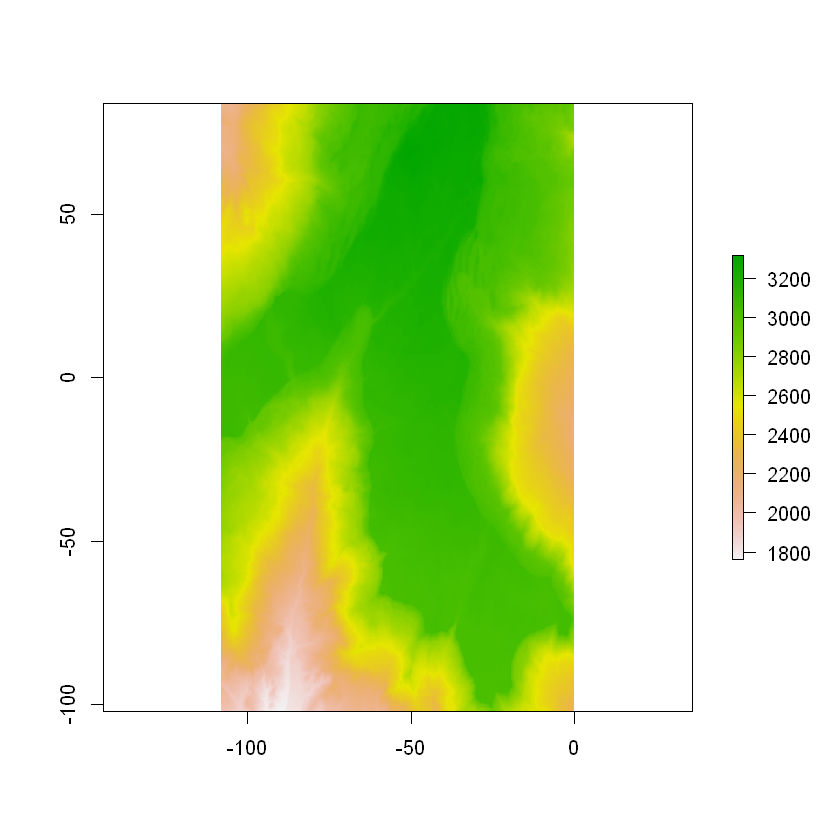

In [99]:
crs(dem) <- CRS(SRS_string=wkt_32613)
extent(dem) <- c(-108.0000, 0.0000, -102.0000, 84.0000)
show(dem)
plot(dem)

In [ ]:
#writeRaster(dem, "SNEX20_DEM_EPSG32613_NK_QC_02102021.tif", overwrite = TRUE)


[**Back to top**](#top)

---
<a id='hdf'></a>
## 2. Working with <b> HDF5 </b> data in R
Package:<b> rgdal </b>Dataset: **[ICESat-2 L3B Monthly Gridded Atmosphere V003 (ATL16)](https://nsidc.org/data/ATL16)**

In [100]:
setwd("C:/Users/niko8816/Projects/tutorials/data/icesat")
path <- getwd()
print(path)

[1] "C:/Users/niko8816/Projects/tutorials/data/icesat"


In [101]:
# Convert a single file
path <- 'C:/Users/niko8816/Projects/tutorials/data/icesat/'
is2_file <- 'ATL17_20190401000537_00420301_954b1_01_HEGOUT.h5'

filepath <- file.path(path, is2_file)
print(filepath)

[1] "C:/Users/niko8816/Projects/tutorials/data/icesat//ATL17_20190401000537_00420301_954b1_01_HEGOUT.h5"


In [102]:
is2_sds <- get_subdatasets(filepath)
is2_sds
# Be careful using this command as the list can be very long with unsubset HDF files.

[1] "HDF5:C:/Users/niko8816/Projects/tutorials/data/icesat//ATL17_20190401000537_00420301_954b1_01_HEGOUT.h5://global_asr"    
[2] "HDF5:C:/Users/niko8816/Projects/tutorials/data/icesat//ATL17_20190401000537_00420301_954b1_01_HEGOUT.h5://global_asr_img"

In [103]:
gdal_translate(is2_sds[1], dst_dataset = "ATL17_global_asr_WGS84.tif")

NULL

In [111]:
gaf <- raster("ATL17_global_asr_WGS84.tif")
gaf

class      : RasterLayer 
dimensions : 180, 360, 64800  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 0, 360, 0, 180  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : C:/Users/niko8816/Projects/tutorials/data/icesat/ATL17_global_asr_WGS84.tif 
names      : ATL17_global_asr_WGS84 


In [112]:
wkt_wgs84 <- 'GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]'

In [113]:
coastlines <- ne_coastline(scale = 110, returnclass = c("sp", "sf"))
show(coastlines)

class       : SpatialLinesDataFrame 
features    : 134 
extent      : -180, 180, -85.60904, 83.64513  (xmin, xmax, ymin, ymax)
crs         : +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 
variables   : 2
names       : scalerank, featurecla 
min values  :         0,  Coastline 
max values  :         3,    Country 


In [116]:
gaf.ext <- raster("ATL17_global_asr_WGS84.tif")
crs(gaf.ext) <- CRS("+proj=longlat +datum=WGS84 +no_defs")
gaf.ext <- setExtent(gaf.ext, coastlines, keepres=FALSE)
show(gaf.ext)
#gaf.ext <- setExtent(gaf.ext, c(-180,180,-90,90), keepres = FALSE)

class      : RasterLayer 
dimensions : 180, 360, 64800  (nrow, ncol, ncell)
resolution : 1, 0.9403009  (x, y)
extent     : -180, 180, -85.60904, 83.64513  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/icesat/ATL17_global_asr_WGS84.tif 
names      : ATL17_global_asr_WGS84 



In [117]:
# As of 2/17/2021, ATL16 and ATL17 data needs to be flipped 180 degrees to properly plot the data
gaf.ext.flip <- flip(gaf.ext, direction='y')

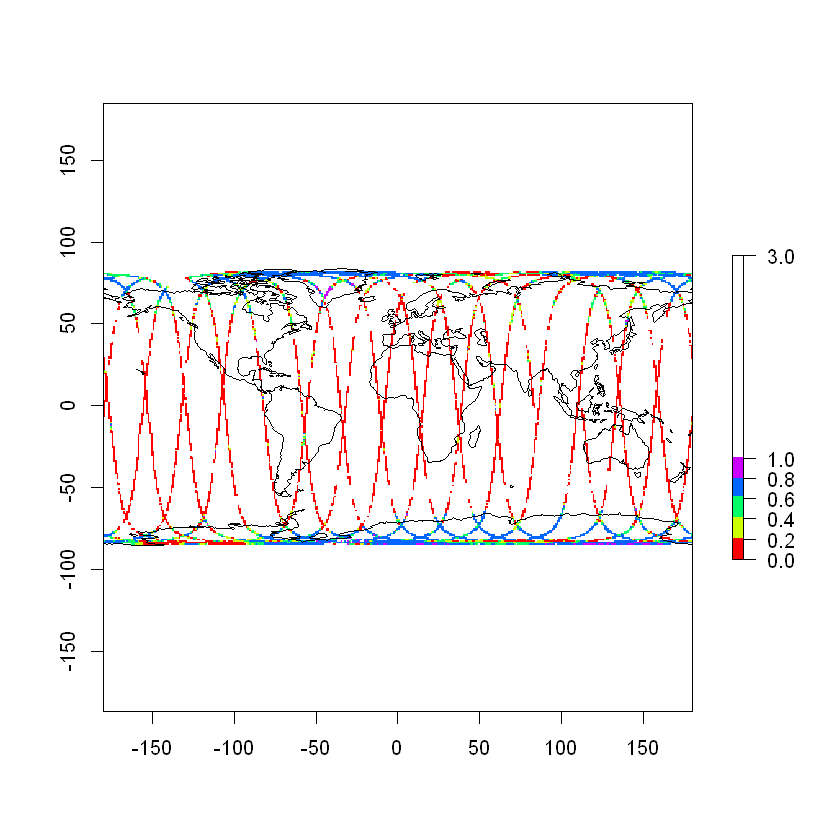

In [128]:
plot(gaf.ext.flip, 
      breaks = c(0.0,0.2, 0.4, 0.6, 0.8, 1.0, 3.0), 
      col = rainbow(5))#,
#      main=file,
#      legend=FALSE,
#      axes=TRUE)
plot(coastlines, add=TRUE)

In [ ]:
# Save the plot
# jpeg(file="saving_plot1.jpeg")
# plot(gaf.ext.flip, 
#      breaks = c(0.2, 0.4, 0.6, 0.8, 1.0), 
#      col = rainbow(5),
#      main=file,
#      legend=FALSE,
#      axes=TRUE)
# plot(coastlines, add=TRUE)
# dev.off()

In [ ]:
# Uncomment the following line if you want to save the final GeoTiff
#writeRaster(gaf.ext.flip, 'ATL16_global_column_od_flip.tif', options=c('TFW=YES', 'XML=YES'))

[**Back to top**](#top)

---
<a id='he5'></a>
## 3. Working with <b>.he5 </b>data in R
Package:<b> rgdal </b>Dataset: **[AMSR-E/AMSR2 Unified L3 Daily 12.5 km Brightness Temperatures, Sea Ice Concentration, Motion & Snow Depth Polar Grids](https://nsidc.org/data/AU_SI12/versions/1)**

In [129]:
# Set workspace (usually where you save your R file)
setwd("C:/Users/niko8816/Projects/tutorials/data/amsr")
path <- getwd()
print(path)

[1] "C:/Users/niko8816/Projects/tutorials/data/amsr"


In [130]:
# Convert a single file
amsr_file <- "AMSR_U2_L3_SeaIce12km_B04_20210219.he5"
amsr_file

[1] "AMSR_U2_L3_SeaIce12km_B04_20210219.he5"

In [131]:
# View subdatasets within the HDF file
amsr_sds <- get_subdatasets(amsr_file)
#amsr_sds

In [136]:
# convert your data slice to .tif and save new file to correct CRS and extent
gdal_translate(amsr_sds[59], dst_dataset = "SI_12km_SH_ICECON_DAY_20210219.tif") #, a_srs = "EPSG:3412", s_srs = "EPSG:3412") #, projwin_srs = "EPSG:3976")
amsr_gaf <- raster("SI_12km_SH_ICECON_DAY_20210219.tif")
show(amsr_gaf)

NULL

class      : RasterLayer 
dimensions : 664, 632, 419648  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 0, 632, 0, 664  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : C:/Users/niko8816/Projects/tutorials/data/amsr/SI_12km_SH_ICECON_DAY_20210219.tif 
names      : SI_12km_SH_ICECON_DAY_20210219 
values     : -2147483648, 2147483647  (min, max)



In [133]:
wkt_south <- 'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic South",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",-70],
    PARAMETER["central_meridian",0],
    PARAMETER["scale_factor",1],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["X",EAST],
    AXIS["Y",NORTH],
    AUTHORITY["EPSG","3976"]]'

In [134]:
crs(amsr_gaf) <- CRS(SRS_string=wkt_south)
extent(amsr_gaf) <- c(-3950000, 3950000, -3950000, 4350000)

class      : RasterLayer 
dimensions : 664, 632, 419648  (nrow, ncol, ncell)
resolution : 12500, 12500  (x, y)
extent     : -3950000, 3950000, -3950000, 4350000  (xmin, xmax, ymin, ymax)
crs        : +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/amsr/SI_12km_SH_ICECON_DAY_20210219.tif 
names      : SI_12km_SH_ICECON_DAY_20210219 
values     : -2147483648, 2147483647  (min, max)



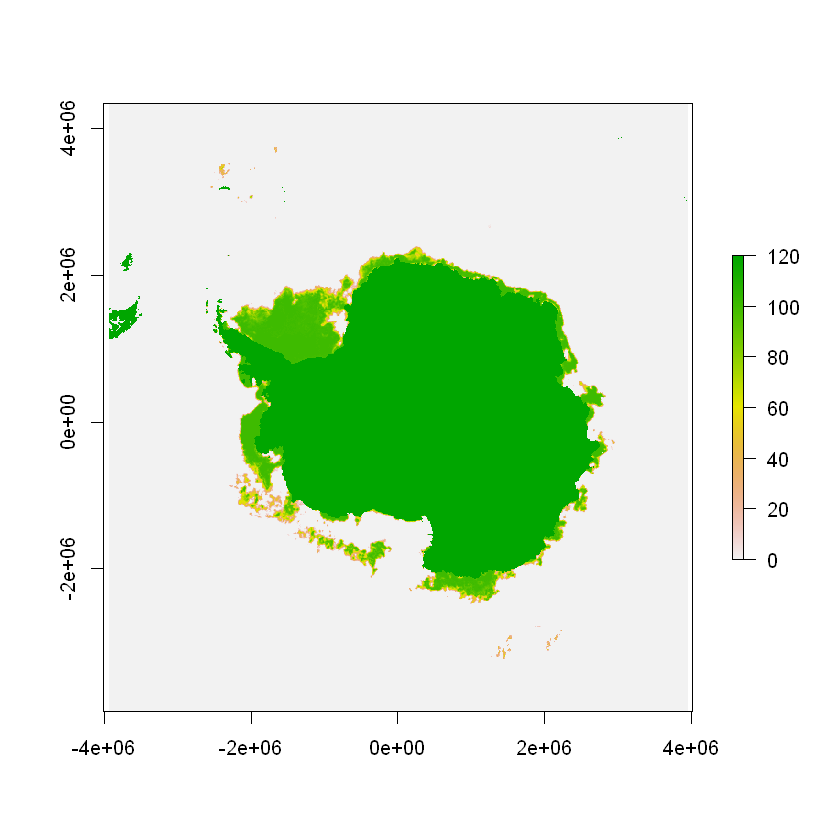

In [135]:
show(amsr_gaf)
plot(amsr_gaf)

In [137]:
amsr_gaf_df <- as.data.frame(amsr_gaf, xy=TRUE)
str(amsr_gaf_df)

min <- minValue(amsr_gaf)
max <- maxValue(amsr_gaf)

'data.frame':	419648 obs. of  3 variables:
 $ x                             : num  0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 ...
 $ y                             : num  664 664 664 664 664 ...
 $ SI_12km_SH_ICECON_DAY_20210219: int  0 0 0 0 0 0 0 0 0 0 ...


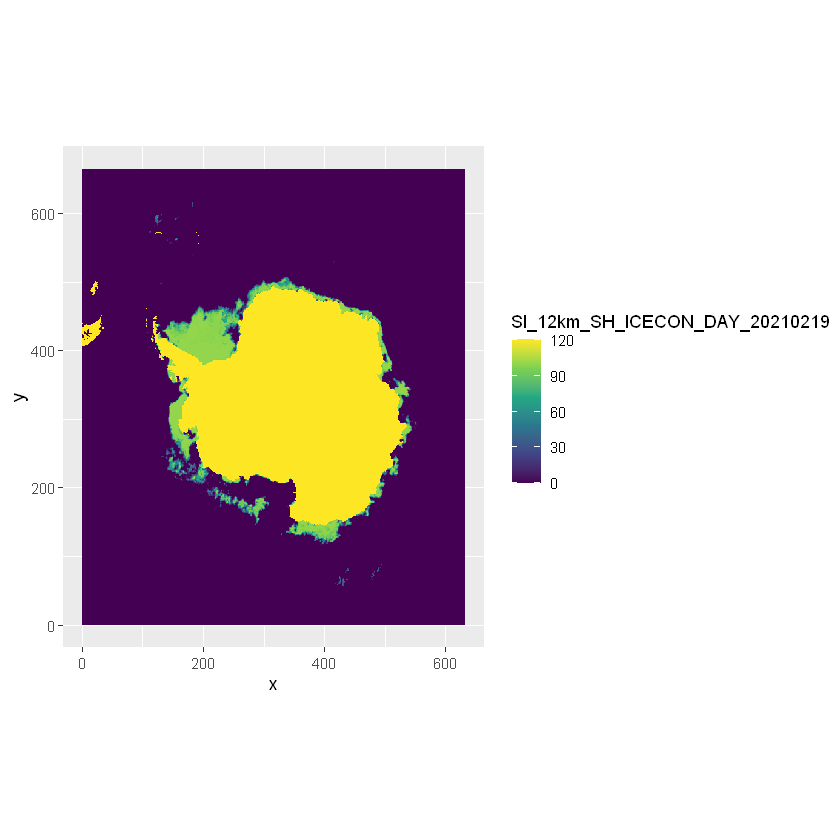

In [138]:
ggplot() +
    geom_raster(data = amsr_gaf_df , aes(x = x, y = y, fill = SI_12km_SH_ICECON_DAY_20210219)) +
    scale_fill_viridis_c() +
    coord_quickmap()

In [ ]:
#writeRaster(amsr_gaf, "SI_12km_SH_ICECON_DAY_020821_extent.tif", overwrite = TRUE)

[**Back to top**](#top)

---
<a id='bin'></a>
## 4. Working with <b>Binary (.bin) </b>data in R
Package:<b> rgdal </b>Dataset: **[Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data, Version 1 (NSIDC-0051)](https://nsidc.org/data/NSIDC-0051/versions/1)**

**Note:** Before you can convert Binary data to a raster, you must first create a _header file (.hdr)_ and place it in your working directory. NSIDC has a _How To_ article that includes the necessary header file information for the Northern and Southern Hemisphere versions of this example data product: https://nsidc.org/support/how/how-do-i-convert-nsidc-0051-sea-ice-concentration-data-binary-geotiff

In [139]:
# Set workspace (usually where you save your R file)
setwd("C:/Users/niko8816/Projects/tutorials/data/0051")
path <- getwd()
print(path)

[1] "C:/Users/niko8816/Projects/tutorials/data/0051"


In [140]:
nt_file <- "nt_20201031_f17_v1.1_s.bin"
nt_file

[1] "nt_20201031_f17_v1.1_s.bin"

In [160]:
gdal_translate(nt_file, 
               of = "GTiff",
               dst_dataset = "nt_test.tif", 
               a_srs = '+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs',
               projwin_srs = '+proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +k=1 +x_0=0 +y_0=0 +a=6378273 +b=6356889.449 +units=m +no_defs',
               a_nodata = 255, 
               a_ullr = c(-3950000.0, 4350000.0, 3950000.0, -3950000.0),
               scale = c(0, 255),
               output_Raster = TRUE, verbose = FALSE);

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded ellps unknown in CRS definition: +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +a=6378273 +rf=298.279411123064 +units=m +no_defs"Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum unknown in CRS definition"

class      : RasterBrick 
dimensions : 332, 316, 104912, 1  (nrow, ncol, ncell, nlayers)
resolution : 25000, 25000  (x, y)
extent     : -3950000, 3950000, -3950000, 4350000  (xmin, xmax, ymin, ymax)
crs        : +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +a=6378273 +rf=298.279411123064 +units=m +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/0051/nt_test.tif 
names      : nt_test 
min values :       0 
max values :     255 


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded ellps unknown in CRS definition: +proj=stere +lat_0=-90 +lat_ts=-70 +lon_0=0 +x_0=0 +y_0=0 +a=6378273 +rf=298.279411123064 +units=m +no_defs"Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
"Discarded datum unknown in CRS definition"

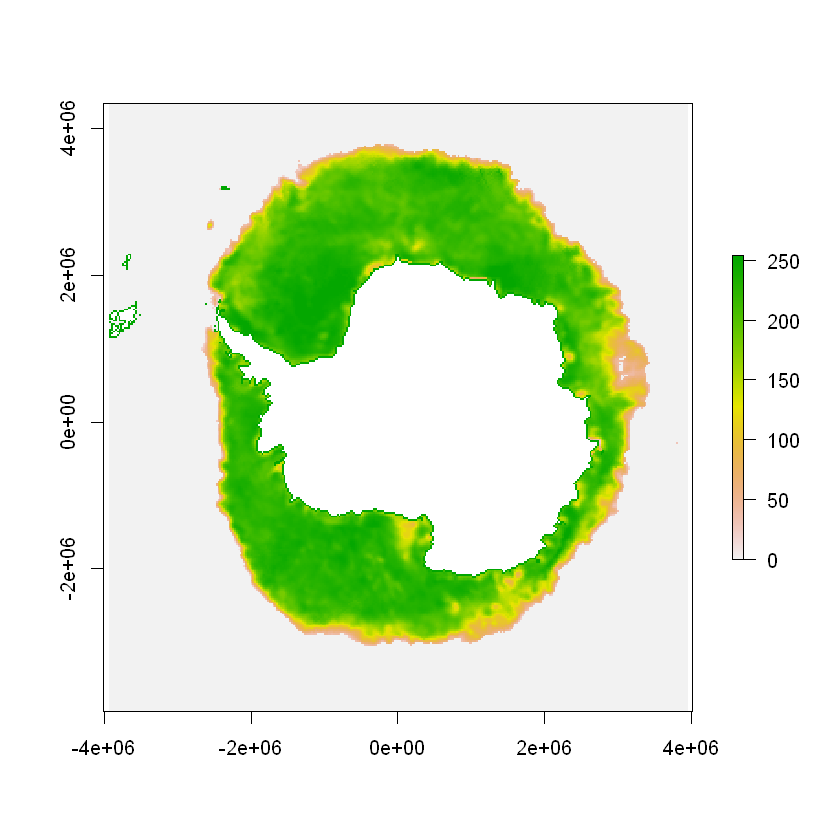

In [161]:
nt_raster <- raster("nt_test.tif")
plot(nt_raster)

[**Back to top**](#top)

---
<a id='mult'></a>
## 5. Working with **Multiple Datasets** in R
Package(s): **rgdal, ggplot2, rgee** </b>Dataset: **MEaSUREs Ice Velocity, GLIMS Glacier Database**

https://github.com/r-spatial/rgee

In [28]:
#library(rgee)
#ee_Initialize()

In [162]:
setwd("C:/Users/niko8816/Projects/tutorials/data")
path <- getwd()
print(path)

[1] "C:/Users/niko8816/Projects/tutorials/data"


In [163]:
file_path <- file.path(path, "glims/glims_polygons.shp")
file_path

pine_island <- st_read(file_path)

[1] "C:/Users/niko8816/Projects/tutorials/data/glims/glims_polygons.shp"

Reading layer `glims_polygons' from data source `C:\Users\niko8816\Projects\tutorials\data\glims\glims_polygons.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 30 fields
geometry type:  POLYGON
dimension:      XYZ
bbox:           xmin: -104.0121 ymin: -80.08553 xmax: -86.55338 ymax: -73.71418
z_range:        zmin: 0 zmax: 0
geographic CRS: WGS 84


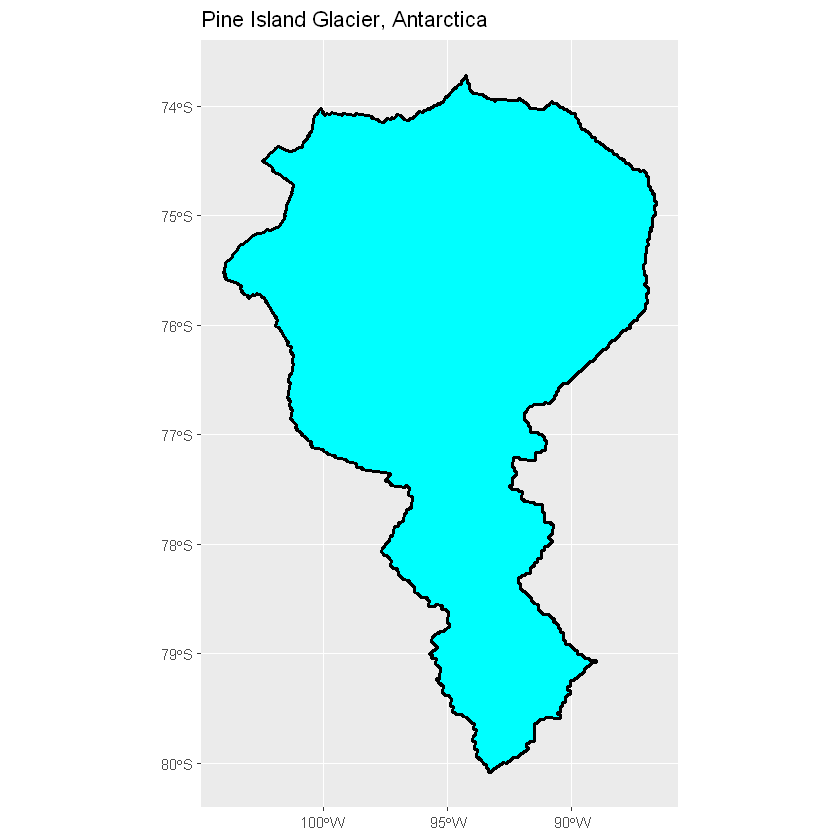

In [164]:
ggplot() + 
  geom_sf(data = pine_island, size = 1, color = "black", fill = "cyan1") + 
  ggtitle("Pine Island Glacier, Antarctica") + 
  coord_sf()

In [165]:
meas_file <- "measures/antarctica_ice_velocity_450m_v2.nc"

meas_path <- file.path(path, meas_file)
meas_path

[1] "C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc"

In [166]:
# View subdatasets within the HDF file
meas_sds <- get_subdatasets(meas_path)
meas_sds

[1] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:lat" 
[2] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:lon" 
[3] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:VX"  
[4] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:VY"  
[5] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:STDX"
[6] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:STDY"
[7] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:ERRX"
[8] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:ERRY"
[9] "NETCDF:C:/Users/niko8816/Projects/tutorials/data/measures/antarctica_ice_velocity_450m_v2.nc:CNT"

In [48]:
gdal_translate(meas_sds[3], dst_dataset = "VX.tif") #, a_srs = "EPSG:3412", s_srs = "EPSG:3412") #, projwin_srs = "EPSG:3976")
gdal_translate(meas_sds[4], dst_dataset = "VY.tif") #, a_srs = "EPSG:3412", s_srs = "EPSG:3412") #, projwin_srs = "EPSG:3976")

NULL

NULL

In [167]:
vx <- raster("VX.tif")
vy <- raster("VY.tif")

show(vx)
show(vy)

class      : RasterLayer 
dimensions : 12445, 12445, 154878025  (nrow, ncol, ncell)
resolution : 450, 450  (x, y)
extent     : -2800225, 2800025, -2800025, 2800225  (xmin, xmax, ymin, ymax)
crs        : +proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/VX.tif 
names      : VX 

class      : RasterLayer 
dimensions : 12445, 12445, 154878025  (nrow, ncol, ncell)
resolution : 450, 450  (x, y)
extent     : -2800225, 2800025, -2800025, 2800225  (xmin, xmax, ymin, ymax)
crs        : +proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 
source     : C:/Users/niko8816/Projects/tutorials/data/VY.tif 
names      : VY 



In [168]:
pine_island_prj <- st_transform(pine_island, crs = st_crs(vx))

Warning message in plot.sf(pine_island_prj, add = TRUE):
"ignoring all but the first attribute"

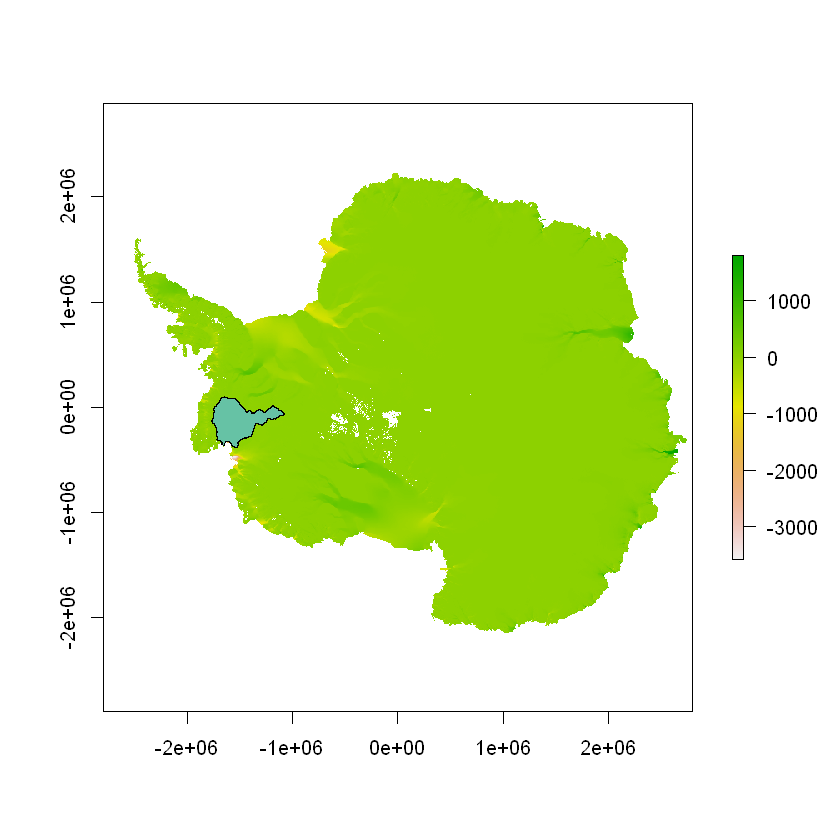

In [169]:
plot(vx)
plot(pine_island_prj, add=TRUE)

In [170]:
vx_crop <- crop(vx, pine_island_prj)

In [171]:
pine_island_prj_df <- fortify(pine_island_prj)

vx_crop_df <- as.data.frame(vx_crop, xy = TRUE) 
str(vx_crop_df)

'data.frame':	1661121 obs. of  3 variables:
 $ x : num  -1775800 -1775350 -1774900 -1774450 -1774000 ...
 $ y : num  99100 99100 99100 99100 99100 99100 99100 99100 99100 99100 ...
 $ VX: num  -3.384 -4.309 -2.396 0.302 -0.365 ...


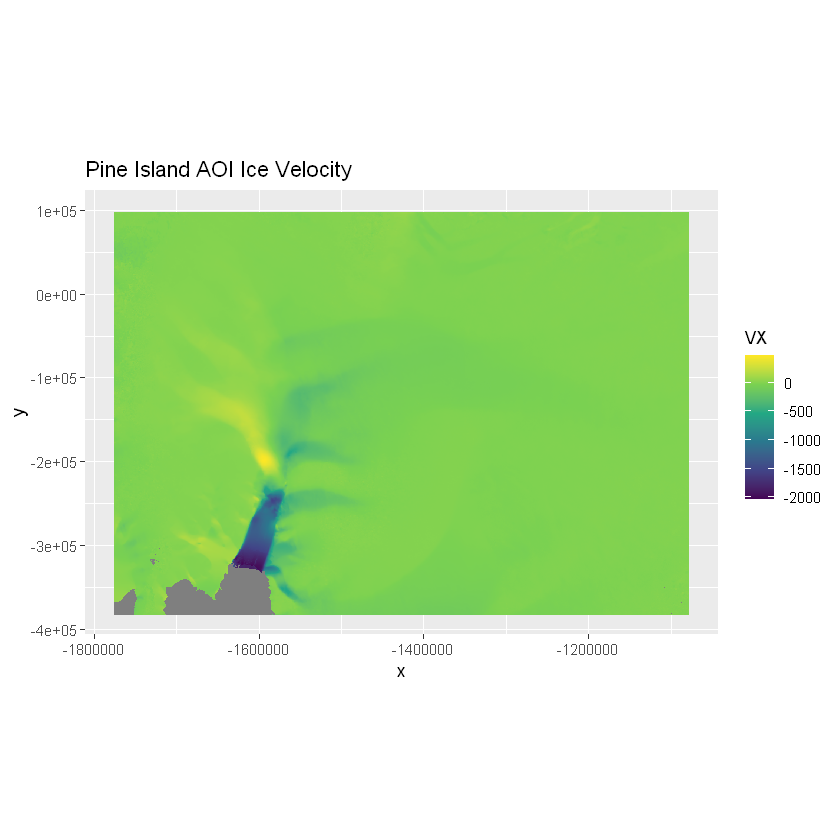

In [86]:
ggplot() +
  geom_raster(data = vx_crop_df, 
              aes(x = x, y = y, 
                  fill = VX)) + 
  scale_fill_viridis_c() +  
  scale_alpha(range = c(0.15, 0.65), guide = "none") +  
  ggtitle("Pine Island Ice Velocity") +
  coord_quickmap()

---
[**Back to top**](#top)